In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
base_folder, thresholds_file = 'results/schaefer400', 'global_metrics.csv'
networks = ['', 'Cont', 'Default', 'DorsAttn', 'SalVentAttn']

In [14]:
df = pd.read_csv(Path(base_folder, thresholds_file), index_col=0)
groups = df['group'].unique()

In [19]:
def add_curve(thresholds, avg_clustering, lower_error, upper_error, group, ax):
    ax.plot(thresholds, avg_clustering, label=group)
    ax.plot(thresholds, lower_error, alpha=0.1)
    ax.plot(thresholds, upper_error, alpha=0.1)
    ax.legend()
    ax.fill_between(thresholds, lower_error, upper_error, alpha=0.2)

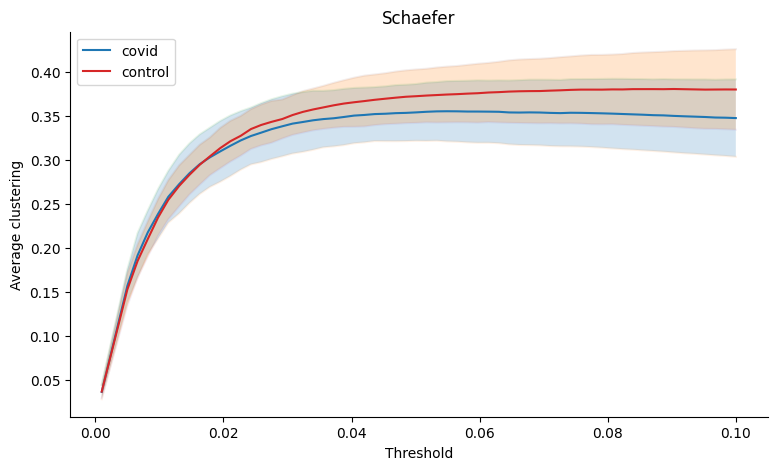

In [21]:
fig, ax = plt.subplots(figsize=(9, 5))
for group in groups:
    group_metrics = df[df['group'] == group]
    thresholds = group_metrics['threshold'].values
    lower_error, upper_error = group_metrics['avg_clustering'] - group_metrics['avg_clustering_std'], group_metrics['avg_clustering'] + group_metrics['avg_clustering_std']
    avg_clustering = group_metrics['avg_clustering'].values
    add_curve(thresholds, avg_clustering, lower_error, upper_error, group, ax)

ax.set_title('Schaefer')
ax.set_xlabel('Threshold')
ax.set_ylabel('Average clustering')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()